In [1]:
import pandas as pd
import numpy as np 

from pyhhmm.gaussian import GaussianHMM

import yfinance as yf

import matplotlib.pyplot as plt

from datetime import datetime

# Data Management

In [2]:
# Data Extraction
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
symbol = "SPY"

# USE YAHOO FINANCE 
data = yf.download(symbol ,  start_date , end_date )
data = data[["Open" , "High" , "Low" , "Close" , "Volume"]]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Add Returns and Range    
# Returns = (todays price divided by yesterdays)     # ROI since Yesterday
# Range   = (todays high price divided todays low)   # volitility from highest point to lowest within day

df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"]   = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)

df


,Open,High,Low,Close,Volume,Returns,Range
Date,,,,,,,
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700,-0.007572,0.007910
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900,0.003815,0.010519
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400,-0.002812,0.004034
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000,0.005330,0.009638
2020-01-09,326.160004,326.730011,325.519989,326.649994,48473300,0.006781,0.003717
...,...,...,...,...,...,...,...
2023-12-04,455.600006,459.119995,454.339996,456.690002,72430900,-0.005249,0.010521
2023-12-05,455.260010,457.589996,454.869995,456.600006,69793500,-0.000197,0.005980
2023-12-06,458.809998,458.839996,454.309998,454.760010,69124700,-0.004030,0.009971


# HMM - Hidden States
- HMM is a model that looks for hidden states in the market
- states
    -  (upward) , (downward) , (sidways), and many more

In [4]:
# Structure Data (create a new dataframe using the returns and range)
x_train = df[[ "Returns" , "Range" ]]
x_train

,Returns,Range
Date,,
2020-01-03,-0.007572,0.007910
2020-01-06,0.003815,0.010519
2020-01-07,-0.002812,0.004034
2020-01-08,0.005330,0.009638
2020-01-09,0.006781,0.003717
...,...,...
2023-12-04,-0.005249,0.010521
2023-12-05,-0.000197,0.005980
2023-12-06,-0.004030,0.009971


# HMM - Learning & Output
- Covarience Types
    - <b>Full</b> means the components may independently adopt any position and shape.

    - <b>Tied</b> means they have the same shape, but the shape may be anything.

    - <b>Diagonal</b> means the contour axes are oriented along the coordinate axes, but otherwise the eccentricities may vary between components.

    - <b>Tied Diagonal</b> is a "tied" situation where the contour axes are oriented along the coordinate axes. (I have added this because initially it was how I misinterpreted "diagonal.")

    - <b>Spherical</b> is a "diagonal" situation with circular contours (spherical in higher dimensions, whence the name).

In [5]:
# Train Model
model = GaussianHMM(n_states=4, covariance_type="full" , n_emissions=2)
model.train([np.array(x_train.values)])

model.__dir__()

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


['n_states',
 'tr_params',
 'init_params',
 'init_type',
 'pi_prior',
 'A_prior',
 'learning_rate',
 'verbose',
 'n_emissions',
 'covariance_type',
 'means_prior',
 'means_weight',
 'covars_prior',
 'covars_weight',
 'min_covar',
 'pi',
 'A',
 'means',
 '_covars',
 '__module__',
 '__doc__',
 '__init__',
 '__str__',
 'covars',
 'get_n_fit_scalars_per_param',
 '_init_model_params',
 '_initialise_sufficient_statistics',
 '_accumulate_sufficient_statistics',
 '_reestimate_stat_obs',
 '_reestimate_stat_obs2',
 '_infer_missing',
 '_M_step',
 '_update_model',
 '_map_B',
 '_calc_conditional_posterior',
 '_calc_sigma',
 '_pdf',
 '_generate_sample_from_state',
 'forward',
 'score',
 'score_samples',
 'predict',
 'predict_proba',
 'decode',
 'train',
 'sample',
 'get_stationary_distribution',
 '_decode_map',
 '_decode_viterbi',
 '_calc_alpha',
 '_calc_beta',
 '_calc_xi',
 '_calc_gamma',
 '_train',
 '_compute_intermediate_values',
 '_E_step',
 '_sum_up_sufficient_statistics',
 '__dict__',
 '__weak

In [6]:
# Check State Categorization
hidden_states = model.predict([x_train.values])[0]
hidden_states

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,

In [7]:
# State Result Means for Each State 
print(f"[Returns avg , Range avg ]")
model.means

[Returns avg , Range avg ]


array([[-0.03457862,  0.0488203 ],
       [ 0.03910711,  0.05034532],
       [-0.0009912 ,  0.02092881],
       [ 0.00148849,  0.00989717]])

In [8]:
# State Result Covariations for Each State 
print(f"[Returns avg , Range avg ]")
model.covars

[Returns avg , Range avg ]


array([[[1.47450468e-03, 2.13553224e-04],
        [2.13553224e-04, 7.76577346e-04]],

       [[1.88510440e-03, 1.22634632e-03],
        [1.22634632e-03, 1.24483526e-03]],

       [[3.04680680e-04, 1.93624744e-05],
        [1.93624744e-05, 9.97074380e-05]],

       [[7.75090093e-05, 1.50394841e-05],
        [1.50394841e-05, 3.42926519e-05]]])

# Data Visualization

In [9]:
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []


prices = df["Close"].values.astype(float)


print("Check pass length of Close matches Hidden states array: " , len(prices)  ==  len(hidden_states)  )


for s in range(0,len(hidden_states), 1):
    if hidden_states[s] == 0:
        labels_0.append(prices[s])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif hidden_states[s]  == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[s])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif hidden_states[s]  == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[s])
        labels_3.append(float('nan'))
    elif hidden_states[s]  == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[s])


labels_0

Check pass length of Close matches Hidden states array:  True


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 322.4200134277344,
 312.6499938964844,
 nan,
 297.510009765625,
 296.260009765625,
 nan,
 300.239990234375,
 nan,
 302.4599914550781,
 nan,
 274.2300109863281,
 nan,
 274.3599853515625,
 248.11000061035156,
 nan,
 239.85000610351562,
 nan,
 240.0,
 nan,
 228.8000030517578,
 222.9499969482422,
 nan,
 246.7899932861328,
 nan,
 253.4199981689453,
 nan,
 257.75,
 246.14999389648438,
 nan,
 248.19000244140625,
 nan,
 265.1300048828125,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 300.6099853515625,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

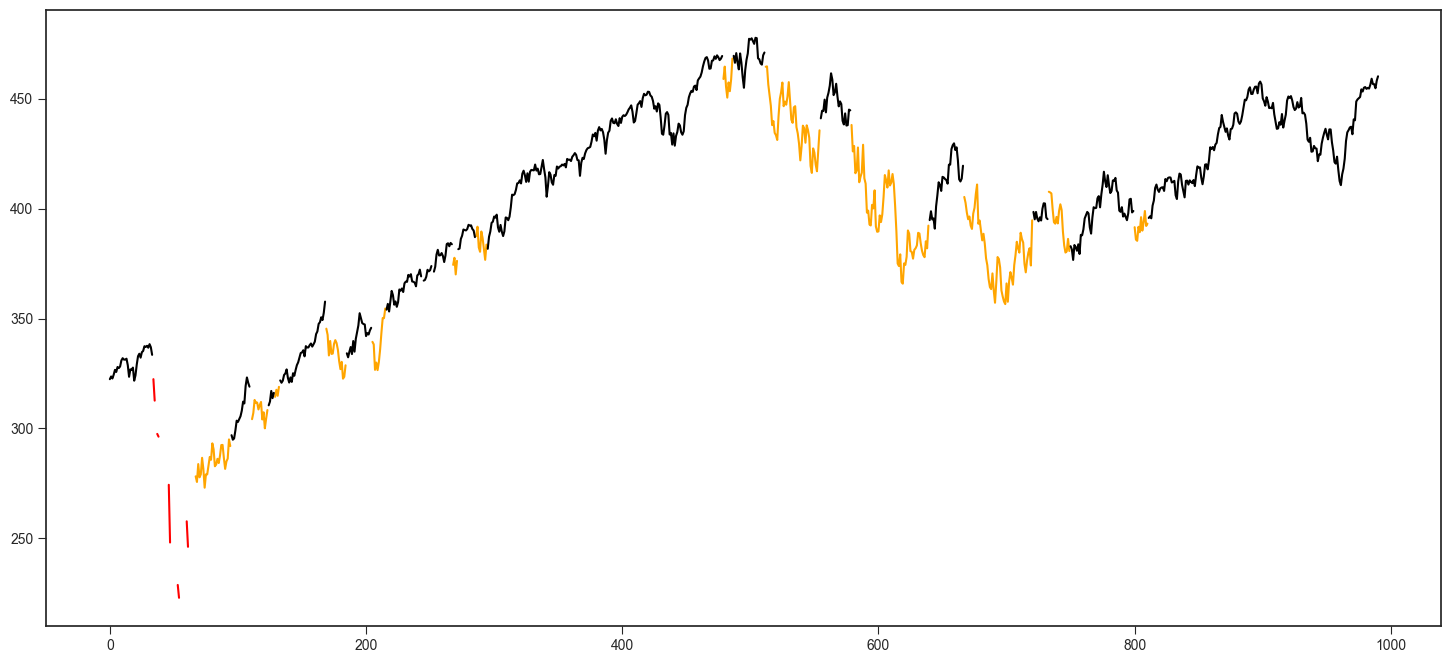

In [10]:
# Plot Chart
figure = plt.figure(figsize=(18,8))

plt.plot(labels_0,color="red")
plt.plot(labels_1,color="green")
plt.plot(labels_2,color="orange")
plt.plot(labels_3,color="black")
plt.show()

# SAVE DATA

In [11]:
df_hmm = df.copy()
df_hmm['hmm'] = hidden_states.tolist()

df_hmm.to_csv(f"data-storage/HMM-{symbol}.csv")
df_hmm

,Open,High,Low,Close,Volume,Returns,Range,hmm
Date,,,,,,,,
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700,-0.007572,0.007910,3
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900,0.003815,0.010519,3
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400,-0.002812,0.004034,3
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000,0.005330,0.009638,3
2020-01-09,326.160004,326.730011,325.519989,326.649994,48473300,0.006781,0.003717,3
...,...,...,...,...,...,...,...,...
2023-12-04,455.600006,459.119995,454.339996,456.690002,72430900,-0.005249,0.010521,3
2023-12-05,455.260010,457.589996,454.869995,456.600006,69793500,-0.000197,0.005980,3
2023-12-06,458.809998,458.839996,454.309998,454.760010,69124700,-0.004030,0.009971,3
